<a href="https://colab.research.google.com/github/shainedl/Papers-Colab/blob/master/Variational_Principal_Components_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.distributions as tdist
from torch.distributions.multivariate_normal import MultivariateNormal as multivariate_normal
import math

In [0]:
class BayesianPCA():
  
  def __init__(self, a_alpha=10e-3, b_alpha=10e-3, a_tau=10e-3, b_tau=10e-3, beta=10e-3):
    
    # hyperparameters
    self.a_alpha = a_alpha
    self.b_alpha = b_alpha
    self.a_tau = a_tau
    self.b_tau = b_tau
    self.beta = beta 
     
  def __reestimate(self):
    """
    Cycle through the groups of variables in turn to re-estimate each distribution 
    """
    
    # observation parameter
    self.tau = self.a_tau_tilde / self.b_tau_tilde

    # latent variables
    self.sigma_x = torch.inverse(torch.eye(self.q) + self.tau *
                   (torch.trace(self.sigma_w) + torch.mm(self.mean_w.t(), self.mean_w)))
    self.mean_x = self.tau * torch.mm(torch.mm(self.sigma_x, self.mean_w.t()),(self.t_n - self.mean_mu))
    
    # observation parameter                                
    self.sigma_mu = torch.eye(self.d) / (self.beta + self.N * self.tau)
    w_x = torch.mm(self.mean_w, self.mean_x)
    sum = 0
    for n in range(self.N):
      sum += torch.sub(self.t_n[:,n], w_x[:,n])
    self.mean_mu = self.tau * torch.mm(self.sigma_mu, torch.reshape(sum, (-1,1)))
        
    # hyperparameter controlling the columns of W
    self.alpha = self.a_alpha_tilde / self.b_alpha_tilde
                                     
    # weight                                 
    self.sigma_w = torch.inverse(torch.diag(self.alpha) + self.tau * 
                   (self.N * self.sigma_x + torch.mm(self.mean_x, self.mean_x.t())))
    self.mean_w = (self.tau * torch.mm(self.mean_x, (torch.sub(self.t_n.t(), self.mean_mu.t())))).t()
   
    # alpha's gamma distribution parameter                            
    self.b_alpha_tilde = self.b_alpha + 0.5 * (torch.trace(self.sigma_w) + torch.diag(torch.mm(self.mean_w.t(), self.mean_w)))                                                     
    # tau's gamma distribution parameter     
    self.b_tau_tilde = torch.tensor([self.b_tau + 0.5 * torch.sum(torch.mm(self.t_n.t(), self.t_n)) + \
                       0.5 * self.N * (torch.trace(self.sigma_mu) + torch.dot(self.mean_mu.flatten(), self.mean_mu.flatten()))+ \
                       0.5 * torch.trace(torch.mm(torch.trace(self.sigma_w) + \
                       torch.mm(self.mean_w.t(), self.mean_w), self.N * self.sigma_x + \
                       torch.mm(self.mean_x, self.mean_x.t()))) + \
                       torch.sum(torch.mm(torch.mm(self.mean_mu.t(), self.mean_w), self.mean_x)) - \
                       torch.sum(torch.mm(torch.mm(self.t_n.t(), self.mean_w), self.mean_x)) - \
                       torch.sum(torch.mm(self.t_n.t(), self.mean_mu))])      
    
  def __get_elbo(self):
    """
    Computes the rigorous lower bound on the true log marginal likelihood 
    
    Returns
    -------
      float
        the lower bound = prior + likelihood - entropy 
    
    """                             
    # random sample
    x = torch.stack([multivariate_normal(self.mean_x[:,n], self.sigma_x).sample() for n in range(self.N)]).t()
    mu = multivariate_normal(self.mean_mu.flatten(), self.sigma_mu).sample()
    w = torch.stack([multivariate_normal(self.mean_w[i], self.sigma_w).sample() for i in range(self.d)])
    alpha = tdist.gamma.Gamma(self.a_alpha_tilde, 1 / self.b_alpha_tilde).sample()     
    tau = tdist.gamma.Gamma(self.a_tau_tilde, 1 / self.b_tau_tilde).sample()
    
    
    # priors
    # p(x) = N(x|0,I_q)
    prior = torch.sum(torch.stack([multivariate_normal(torch.zeros(self.q), \
              torch.eye(self.q)).log_prob(x[:,i]) for i in range(self.N)]))
    
    # p(w|alpha) = conditional distribution                   
    prior += torch.sum(torch.stack([(self.d / 2) * torch.log(alpha[i] / \
              (2 * math.pi)) - 0.5 * alpha[i] * torch.sum(w[:,i]**2) \
              for i in range(self.q)]))                
                                 
    # p(alpha) = Gamma(a, b)                             
    prior += torch.sum((tdist.gamma.Gamma(self.a_alpha, 1/self.b_alpha)).log_prob(alpha))                   
                                 
    # p(mu) = N(mu|0,Beta^-1I)       
    prior += multivariate_normal(torch.zeros(self.d), torch.eye(self.d)/self.beta).log_prob(mu)
                    
    # p(tau) = Gamma(c, d)      
    prior += torch.sum((tdist.gamma.Gamma(self.a_tau, 1/self.b_tau)).log_prob(tau))            
    
    
    # log likelihood of the conditional distribution 
    # p(t_n | x_n, W, mu, tau)
    w_x = torch.mm(w, x)
    list_t = []
    for n in range(self.N):
      list_t.append(w_x[:,n] + mu)
    likelihood = torch.sum(torch.stack([multivariate_normal(torch.stack(list_t).t()[:,n], \
                  torch.eye(self.d) / tau).log_prob(self.t_n[:,n]) for n in range(self.N)]))                 

    # entropy
    # q(x) 
    entropy = self.N * (0.5 * torch.log(torch.cholesky(self.sigma_x).diag().prod()**2 \
                + (self.d / 2) * (1 + torch.log(torch.Tensor([2 * math.pi])))))   
                       
    # q(mu)
    entropy += 0.5 * torch.log(torch.cholesky(self.sigma_mu).diag().prod()**2 \
                + (self.d / 2) * torch.log(torch.Tensor([2 * math.pi])))
                            
    # q(W)          
    entropy += self.d * (0.5 * torch.log(torch.cholesky(self.sigma_w).diag().prod()**2 \
                + (self.d / 2) * torch.log(torch.Tensor([2 * math.pi]))))  
                         
    # q(alpha)
    entropy += self.q * (torch.log(torch.lgamma(torch.Tensor([self.a_alpha_tilde])).exp()) \
                        - (self.a_alpha_tilde - 1) \
                        * torch.digamma(torch.Tensor([self.a_alpha_tilde])) + self.a_alpha_tilde)
    for i in range(self.q):
      entropy -= torch.log(self.b_alpha_tilde[i])
                         
    # q(tau)   
    entropy += - (self.a_tau_tilde - 1) * torch.digamma(torch.Tensor([self.a_tau_tilde])) - \
               torch.log(self.b_tau_tilde) + self.a_tau_tilde  
    # will ignore torch.log(torch.lgamma(torch.Tensor([self.a_tau_tilde])).exp()) since = inf
    
    return prior + likelihood - entropy 
  
  def fit(self, t_n, iterations = 1000, threshold = 1.0):
    """
    Fits the data
    
    Parameters 
    ----------
    t_n : d x N matrix
      observed data to be fit
      
    iterations: int
      number of iterations to re-estimate the lower bound
    
    threshold: float
      determines convergence
      
    """
    self.t_n = t_n
    self.d = self.t_n.shape[0]                     
    self.q = self.d - 1
    self.N = self.t_n.shape[1]   
    
    # variational parameters
    self.mean_x = torch.randn(self.q, self.N)
    self.sigma_x = torch.eye(self.q)
    self.mean_mu = torch.randn(self.d, 1)
    self.sigma_mu = torch.eye(self.d)
    self.mean_w = torch.randn(self.d, self.q)
    self.sigma_w = torch.eye(self.q)
    self.a_alpha_tilde = self.a_alpha + self.d / 2
    self.b_alpha_tilde = torch.abs(torch.randn(self.q))  
    self.a_tau_tilde = self.a_tau + self.N * self.d / 2
    self.b_tau_tilde = torch.abs(torch.randn(1))
             
    self.elbos = [self.__get_elbo()]  
    for i in range(iterations):
      self.__reestimate()
      self.elbos.append(self.__get_elbo())
      if torch.abs(self.elbos[-2] - self.elbos[-1]) <= threshold:
        print('ELBO converged.')
        print("Iterations: ", i+1)                   
        print("ELBO: ", int(self.elbos[-1])) 
        break
              
      if (i+1) % 100 == 0:
        print("Iterations: ", i+1)                   
        print("ELBO: ", int(self.elbos[-1])) 
        
        if i == iterations:
          print('Ended without convergence.')

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

def hinton(matrix, max_weight=None, ax=None):
    """
    Draw Hinton diagram for visualizing a weight matrix.
    From https://matplotlib.org/3.1.1/gallery/specialty_plots/hinton_demo.html
    
    """
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

tensor([[-2.1353e+00, -7.0041e-01, -1.8042e+00, -4.6449e+00, -2.0855e+00,
          2.4061e-01,  2.3531e+00,  1.0547e+00, -2.5082e+00,  2.8340e-01,
         -1.4685e+00,  6.1246e-01, -7.8829e-01, -2.7179e+00, -1.8902e+00,
          3.6274e-01, -3.3849e+00,  5.0054e-01,  3.6157e+00, -2.1100e+00,
         -2.1670e-01,  1.7288e+00,  3.4352e+00,  1.0332e+00, -7.9964e-02,
          2.5562e+00,  2.4328e+00, -1.1508e+00,  1.1279e+00, -1.8129e-01,
          6.0997e-01,  9.7176e-01,  7.9352e-01, -7.9286e-01, -1.8781e+00,
         -4.5199e-01,  7.3514e-01, -4.5349e+00,  5.4989e-01,  1.0770e+00,
         -2.5894e+00,  3.7157e+00,  3.9264e+00,  3.2652e-01, -2.2121e+00,
         -1.6374e+00, -2.2648e+00, -7.0610e-01,  1.0082e+00, -6.1526e-01,
         -1.8178e+00, -5.3216e-01,  1.3734e+00,  3.2996e-01,  1.1243e+00,
          1.2932e+00,  1.8312e+00,  3.9696e+00, -5.1162e+00,  2.0104e+00,
          5.6794e-01,  5.7152e-01, -3.3005e+00, -2.6957e+00, -6.1891e-01,
          6.4333e-01, -1.9379e+00,  3.

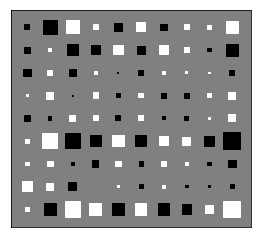

In [218]:
"""
We generate 100 data points in d = 10 dimensions from a Gaussian distribution 
having standard deviations of (5, 4, 3, 2) along four orthogonal directions 
and a standard deviation of 1 in the remaining five directions
"""
m = tdist.multivariate_normal.MultivariateNormal(torch.zeros(10), torch.diag(torch.Tensor([5,4,3,2,1,1,1,1,1,1])))
X = m.sample(sample_shape=torch.Size([100])).t()

"""
Hinton diagram of <W> from variational Bayesian PCA 
"""
test = BayesianPCA()
test.fit(X,1) 
hinton(test.mean_w)